# Explore here

### Paso 1: Planteamiento del problema y recopilación de datos

**Predecir el coste del seguro médico de una persona**

La importante compañía de seguros 4Geeks Insurance S.L. quiere calcular, en función de los datos fisiológicos de sus clientes, cuál va a ser la prima (coste) que debe asumir cada uno de ellos. Para ello, ha reunido a un equipo completo de médicos y en función de datos de otras compañías y un estudio particular han logrado reunir un conjunto de datos para entrenar un modelo predictivo.


In [98]:
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import json
from numpy._core.defchararray import upper
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
from sklearn.feature_selection import f_classif, SelectKBest

In [99]:
url = "https://breathecode.herokuapp.com/asset/internal-link?id=929&path=medical_insurance_cost.csv"

total_data = pd.read_csv(url)
total_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Paso 2: Exploración y limpieza de datos
Hay que conocer las dimensiones y tipologías de datos del objeto con el que estamos trabajando es vital. Para ello necesitamos el atributo shape para obtener las dimensiones del objeto y la función info() para conocer la tipología y la cantidad de valores no nulos:

In [100]:
#Conocer las dimensiones
total_data.shape
print(f"Hay {total_data.shape[0]} filas y {total_data.shape[1]} columnas")

Hay 1338 filas y 7 columnas


In [101]:
# Obtener información sobre tipos de datos y valores no nulos
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [102]:
vars_numericas = total_data.select_dtypes(include=["int64", "float64"]).columns.tolist()
vars_categoricas = total_data.select_dtypes(include=["object"]).columns.tolist()
print(vars_categoricas,vars_numericas)

['sex', 'smoker', 'region'] ['age', 'bmi', 'children', 'charges']




**Eliminación de duplicados**

In [103]:
num_duplicates = total_data.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicates}")

if num_duplicates > 0:
    total_data = total_data.drop_duplicates()
    print(f"Número duplicados borrados. Ahora hay {total_data.shape[0]} datos")
else:
    print("No se han encontrado duplicados")

Número de filas duplicadas: 1
Número duplicados borrados. Ahora hay 1337 datos


### Paso 3: Análisis de variables univariante
Una variable univariante es un término estadístico que se emplea para referenciar un conjunto de observaciones de un atributo. Esto es, el análisis columna a columna del DataFrame. Para ello, debemos distinguir si una variable es categórica o numérica, ya que el cuerpo del análisis y las conclusiones que se pueden obtener serán distintas.

**Análisis sobre variables categóricas**:

Una variable categórica es un tipo de variable que puede tomar uno de un número limitado de categorías o grupos. Estos grupos son a menudo nominales (por ejemplo, el color de un coche: rojo, azul, negro, etc, pero ninguno de estos colores es inherentemente "mayor" o "mejor" que los demás) pero pueden también representarse mediante números finitos.

Para representar este tipo de variables utilizaremos histogramas.


Las variables categóricas son ['sex', 'smoker', 'region']


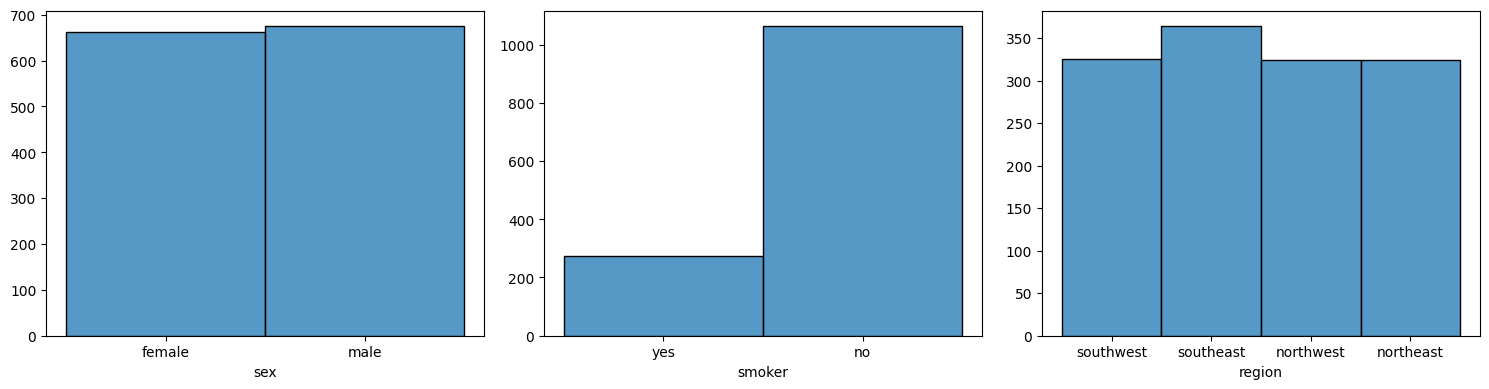

In [104]:
print(f"Las variables categóricas son {vars_categoricas}")


n_cols = 3
n_rows = math.ceil(len(vars_categoricas) / n_cols)

fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))

for i, col in enumerate(vars_categoricas):
    sns.histplot(ax=axis[i],data=total_data,x=col).set_ylabel(None)
    
for j in range(i + 1, len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()


1. Semejanza entre hombres y mujeres
2. Pocos fumadores 
3. Regiones semejantes

**Análisis sobre variables numéricas**:

Una variable numérica es un tipo de variable que puede tomar valores numéricos (enteros, fracciones, decimales, negativos, etc.) en un rango infinito. Una variable categórica numérica puede ser también una variable numérica (por ejemplo, para los sucesivos análisis, podemos tomar la clase Survived como numérica también para estudiar relaciones). Normalmente se representan utilizando un histograma y diagramas de caja, expuestos juntos.

Las variables numéricas son ['age', 'bmi', 'children', 'charges']


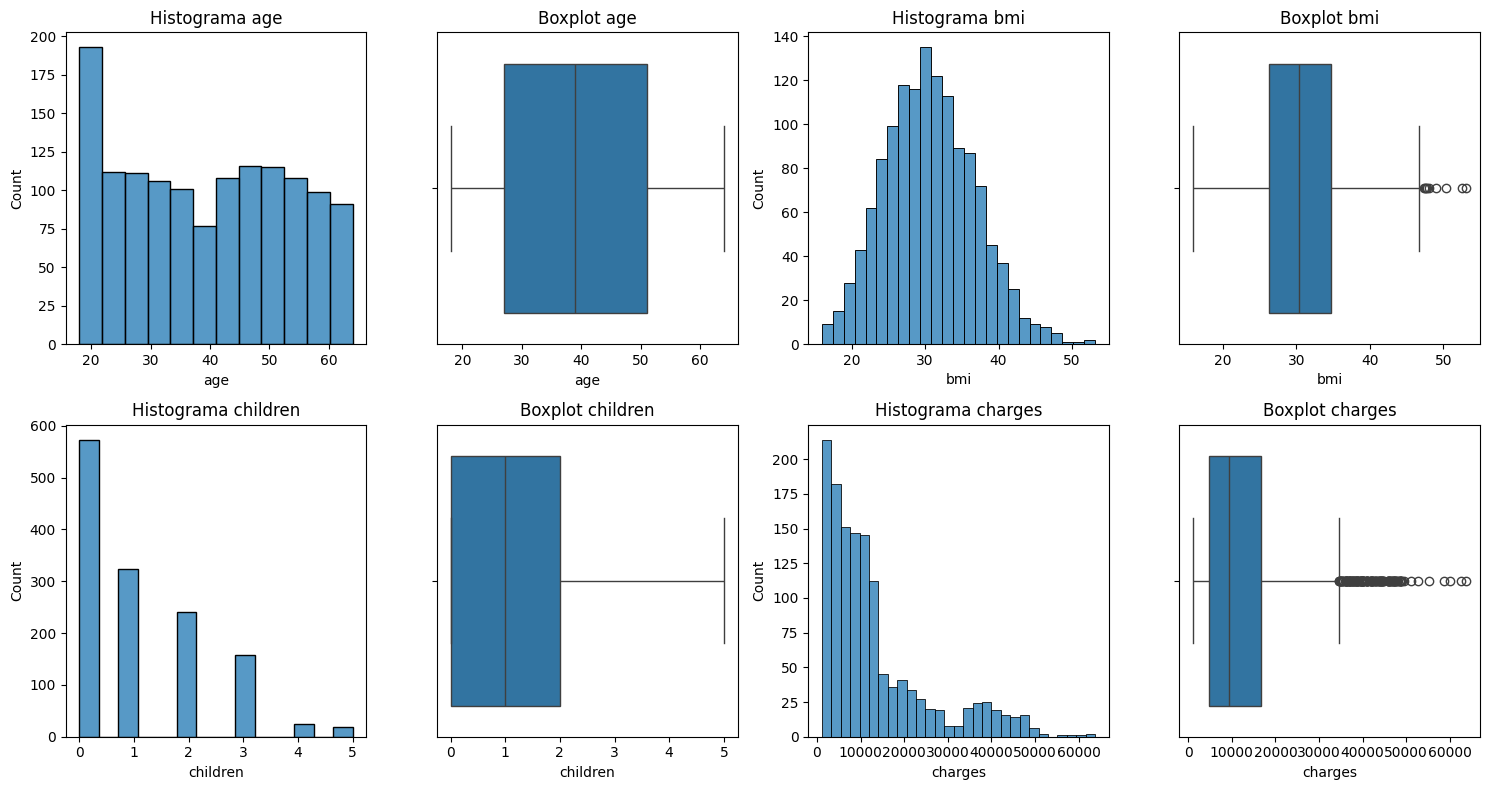

In [105]:
print(f"Las variables numéricas son {vars_numericas}")

n_cols = 4
n_rows = 2*(math.ceil(len(vars_numericas) / n_cols))

fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axis = axis.flatten()

for i, col in enumerate(vars_numericas):
    sns.histplot(data=total_data, x=col, ax=axis[2*i])
    axis[2*i].set_title(f"Histograma {col}")

    sns.boxplot(data=total_data, x=col, ax=axis[2*i + 1])
    axis[2*i + 1].set_title(f"Boxplot {col}")

# Eliminar subplots sobrantes
for j in range(2*i + 2, len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()


### Paso 4: Análisis de variables multivariante

Tras analizar las características una a una, es momento de analizarlas en relación con la predictora y con ellas mismas, para sacar conclusiones más claras acerca de sus relaciones y poder tomar decisiones sobre su procesamiento.

Así, si quisiéramos eliminar una variable debido a una alta cantidad de valores nulos o ciertos outliers, es necesario antes aplicar este proceso para asegurar que la eliminación de ciertos valores no son críticos

**Análisis numérico-numérico:**

Cuando las dos variables que se comparan tienen datos numéricos, se dice que el análisis es numérico-numérico. Para comparar dos columnas numéricas se utilizan diagramas de dispersión y análisis de correlaciones.

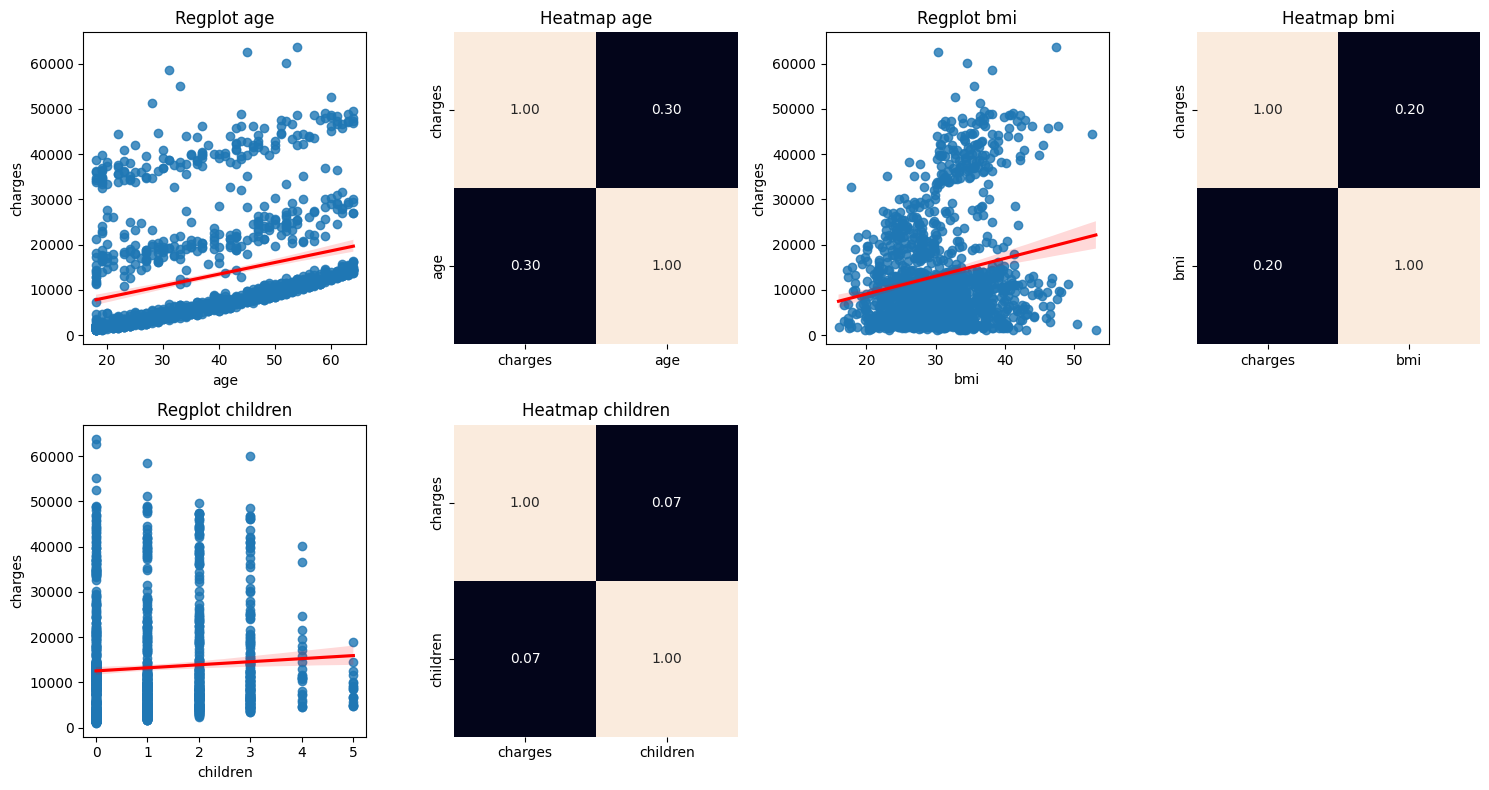

In [106]:
n_cols = 4
target="charges"
vars_num_sin_pred=[col for col in vars_numericas if col != target]
n_rows =2*( math.ceil(len(vars_num_sin_pred) / n_cols))

fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axis = axis.flatten()
for i, col in enumerate(vars_num_sin_pred):
    sns.regplot(ax = axis[2*i], data = total_data, x = col, y = "charges",line_kws={"color": "red"})
    axis[2*i].set_title(f"Regplot {col}")
    sns.heatmap(total_data[["charges",col]].corr(), annot = True, fmt = ".2f", ax = axis[2*i + 1], cbar = False)
    axis[2*i + 1].set_title(f"Heatmap {col}")

# Eliminar subplots sobrantes
for j in range(2*i + 2, len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()


Aunque la cantidad de niños sea una variable numéricas. Se puede considerar una categórica.

**Análisis categórico-categórico**

Cuando las dos variables que se comparan tienen datos categóricos, se dice que el análisis es categórico-categórico. Para comparar dos columnas categóricas se utilizan histogramas y combinaciones.


In [107]:
vars_categoricas_n=[]
for col in vars_categoricas:
    total_data[f"{col}_n"] = pd.factorize(total_data[col])[0]
    vars_categoricas_n.append(f"{col}_n")
    

for col in vars_categoricas:
    transformation_rules = {row[f"{col}"]: row[f"{col}_n"]
    for _, row in total_data[[f"{col}_n", col]].drop_duplicates().iterrows()}

    nombrearchivo = f"./{col}_transformation_rules.json"
    with open(nombrearchivo,"w") as f:
        json.dump(transformation_rules, f)


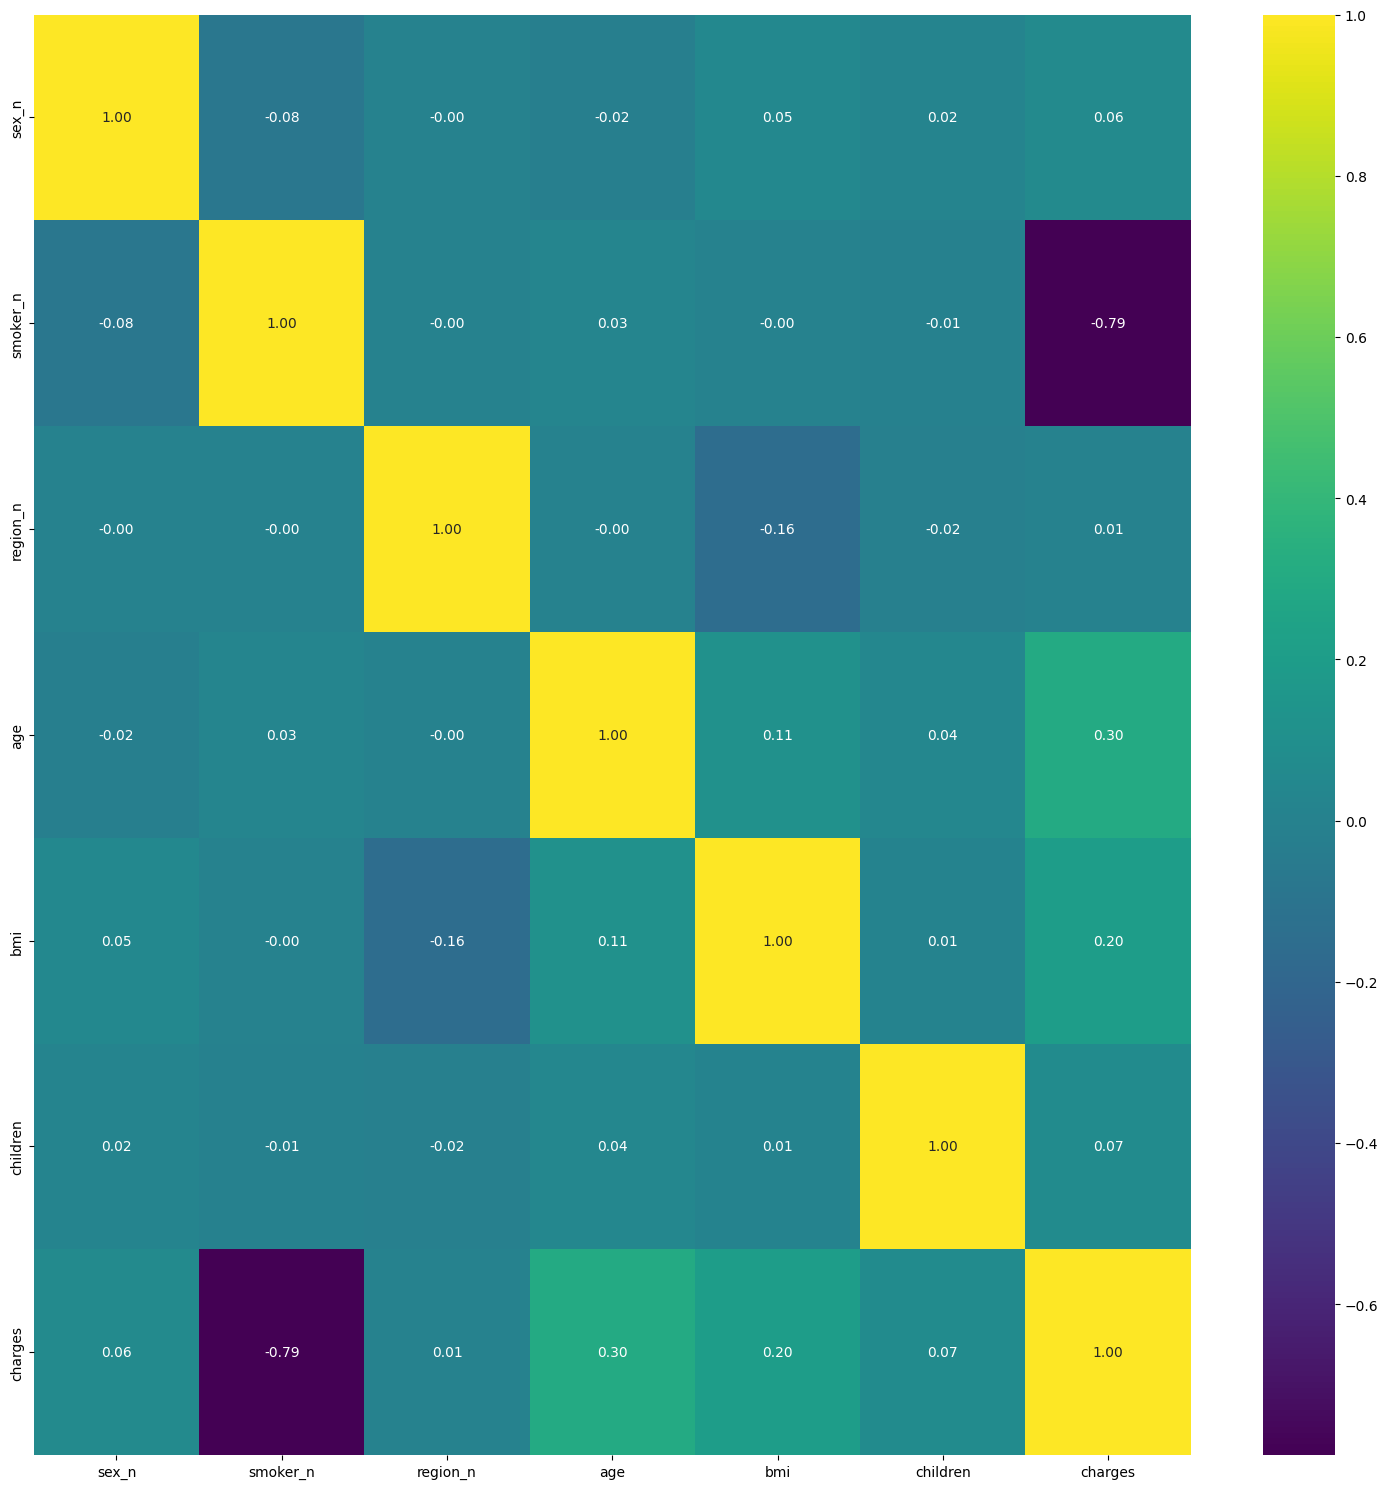

In [108]:
vars_final=vars_categoricas_n+vars_numericas
total_data=total_data[vars_final]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(total_data[vars_final].corr(method="pearson"), annot=True, fmt=".2f", cmap="viridis", ax=ax)
plt.tight_layout()
plt.show()

La condición de ser fumador infuye lógicamente en el precio del seguro. La región, el sexo y la cantidad de hijos no influye demasiado, mientras que la edad y el bmi infuye ligeramente.

## Paso 5: Ingeniería de características

La ingeniería de características (*feature engineering*) es un proceso que implica la creación de nuevas características (o variables) a partir de las existentes para mejorar el rendimiento del modelo. Esto puede implicar una variedad de técnicas como la normalización, la transformación de los datos, etcétera. El objetivo es mejorar la precisión del modelo y/o reducir la complejidad del mismo, facilitando así su interpretación.

En los pasos previos hemos empezado a trabajar con los datos eliminando duplicados, contabilizando los valores nulos e, incluso, para calcular correlaciones. Si bien esto podríamos haberlo hecho en este paso, ya que forma parte de la ingeniería de características, normalmente suele hacerse antes de analizar las variables, separando este proceso en uno previo y este que vamos a ver a continuación.

**Análisis de outliers**

Un valor atípico (*outlier*) es un punto de datos que se desvía significativamente de los demás. Es un valor que es notablemente diferente de lo que sería de esperar dada la tendencia general de los datos. Estos outliers pueden ser causados por errores en la recolección de datos, variaciones naturales en los datos, o pueden ser indicativos de algo significativo, como una anomalía o evento extraordinario.

El análisis descriptivo es una poderosa herramienta para caracterizar el conjunto de datos: la media, desviación y los cuartiles nos brindan una poderosa información sobre cada variable. La función `describe()` de un DataFrame nos ayuda a calcular en unos tiempos muy reducidos todos estos valores.

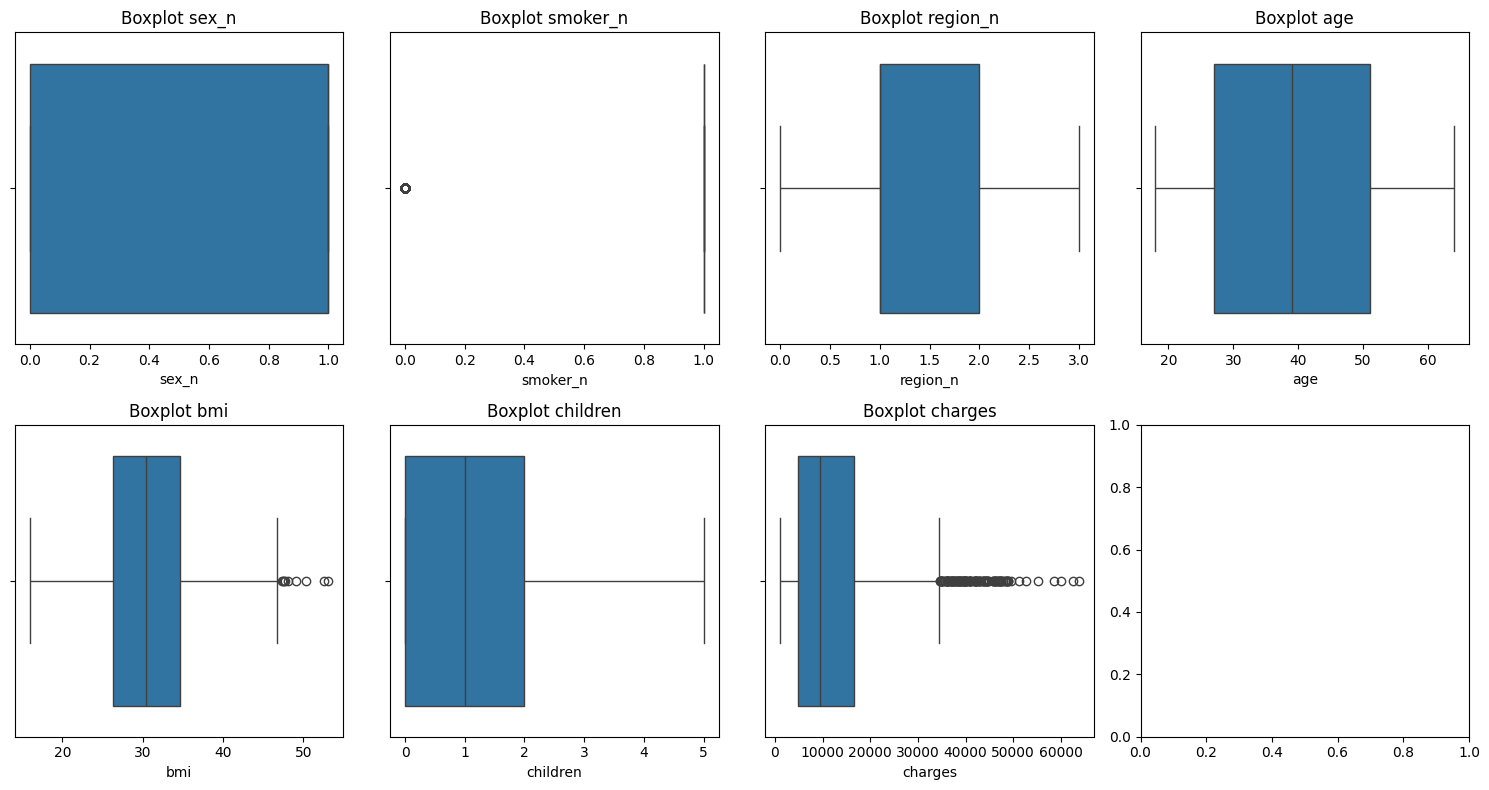

In [109]:
n_cols = 4
n_rows = math.ceil(len(vars_final) / n_cols)

fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axis = axis.flatten()

for i, col in enumerate(vars_final):
    sns.boxplot(data=total_data, x=col, ax=axis[i])
    axis[i].set_title(f"Boxplot {col}")

# Eliminar subplots sobrantes
for j in range(2*i + 2, len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()


In [110]:
total_data.describe()

,sex_n,smoker_n,region_n,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,0.504862,0.795064,1.483919,39.222139,30.663452,1.095737,13279.121487
std,0.500163,0.403806,1.105208,14.044333,6.100468,1.205571,12110.359656
min,0.000000,0.000000,0.000000,18.000000,15.960000,0.000000,1121.873900
25%,0.000000,1.000000,1.000000,27.000000,26.290000,0.000000,4746.344000
50%,1.000000,1.000000,1.000000,39.000000,30.400000,1.000000,9386.161300
75%,1.000000,1.000000,2.000000,51.000000,34.700000,2.000000,16657.717450
max,1.000000,1.000000,3.000000,64.000000,53.130000,5.000000,63770.428010


Hay una cantidad importante de outliers en el bmi

In [111]:
# TENEMOS QUE GUARDARNOS TODOS LOS DATASETS, ES DECIR:

total_data_CON_outliers = total_data.copy()
total_data_SIN_outliers = total_data.copy() # Lo vamos a modificar. Para cada variable con outliers, reemplazamos sus valores outliers

outliers_cols = ["bmi"]

def replace_outliers(column, df):
  col_stats = total_data[column].describe()
  col_iqr = col_stats["75%"] - col_stats["25%"]
  upper_limit = round(float(col_stats["75%"] + 1.5 * col_iqr), 2)
  lower_limit = round(float(col_stats["25%"] - 1.5 * col_iqr), 2)

  if lower_limit < 0: lower_limit = min(df[column])
  # Vamos a quitar los outliers superiores
  df[column] = df[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
  # Vamos a quitar los outliers inferiores
  df[column] = df[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
  return df.copy(), [lower_limit, upper_limit]

outliers_dict = {}
for column in outliers_cols:
  total_data_SIN_outliers, limits = replace_outliers(column, total_data_SIN_outliers)
  outliers_dict.update({column: limits})

outliers_dict # Este JSON me lo tengo que GUARDAR
with open("./outliers_dict.json", "w") as f:
  json.dump(outliers_dict, f)

**Análisis de valores faltantes**

Un *valor faltante* (*missing value*) es un espacio que no tiene valor asignado en la observación de una variable específica. Este tipo de valores son bastante comunes y pueden surgir por muchas razones. Por ejemplo, podría haber un error en la recopilación de datos, alguien podría haberse negado a responder una pregunta en una encuesta, o simplemente podría ser que cierta información no esté disponible o no sea aplicable.

La función `isnull()` es una poderosa herramienta para obtener esta información:


In [112]:
total_data_CON_outliers.isnull().sum().sort_values(ascending=False)

sex_n       0
smoker_n    0
region_n    0
age         0
bmi         0
children    0
charges     0
dtype: int64

No hay nulos en ninguna de los data sets

## Paso 5.5: Aplicación

El *escalado de valores* (*feature scaling*) es un paso crucial en el preprocesamiento de datos para muchos algoritmos de Machine Learning. Es una técnica que cambia el rango de los valores de los datos para que puedan ser comparables entre sí. El escalado normalmente implica la normalización, que es el proceso de cambiar los valores para que tengan una media de 0 y una desviación estándar de 1. Otra técnica común es el escalado mínimo-máximo, que transforma los datos para que todos los valores estén entre 0 y 1.

Antes de escalar los valores, debemos asegurarnos de que todas nuestras variables predictoras sean numéricas. Una vez preparadas, podemos aplicar técnicas como la normalización o el escalado Min-Max directamente sobre el dataset completo. Más adelante, cuando pasemos a la fase de modelado, será el momento de dividir los datos en entrenamiento y prueba.

In [113]:
# total_data_SIN_outliers
# total_data_CON_outliers
predictoras=[col for col in vars_final if col != target]
X_CON = total_data_CON_outliers.drop(target, axis = 1)[predictoras]
X_SIN = total_data_SIN_outliers.drop(target, axis = 1)[predictoras]
y = total_data_CON_outliers[target]

X_train_CON_outliers, X_test_CON_outliers, y_train, y_test = train_test_split(X_CON, y, test_size = 0.2, random_state = 10)
X_train_SIN_outliers, X_test_SIN_outliers = train_test_split(X_SIN, test_size = 0.2, random_state = 10)



De esta forma podemos simplificar el número de variables y trazar nuevas relaciones con la clase predictora.

#### Escalado de valores

El **escalado de valores** (*feature scaling*) es un paso crucial en el preprocesamiento de datos para muchos algoritmos de Machine Learning. Es una técnica que cambia el rango de los valores de los datos para que puedan ser comparables entre sí. El escalado normalmente implica la normalización, que es el proceso de cambiar los valores para que tengan una media de 0 y una desviación estándar de 1. Otra técnica común es el escalado mínimo-máximo, que transforma los datos para que todos los valores estén entre 0 y 1.

Antes de escalar los valores, debemos asegurarnos de que todas nuestras variables predictoras sean numéricas. Una vez preparadas, podemos aplicar técnicas como la normalización o el escalado Min-Max directamente sobre el dataset completo. Más adelante, cuando pasemos a la fase de modelado, será el momento de dividir los datos en entrenamiento y prueba.

In [114]:
# X_train_CON_outliers
# X_train_SIN_outliers

# X_test_CON_outliers
# X_test_SIN_outliers

# TENGO QUE GUARDARME TRES SITUACIONES: 1) DATASET SIN TOCAR, 2) DATASET NORMALIZADO, 3) DATASET MIN-MAX

## NORMALIZACIÓN
### CON OUTLIERS
norm_CON_outliers = StandardScaler()
norm_CON_outliers.fit(X_train_CON_outliers)

X_train_CON_outliers_norm = norm_CON_outliers.transform(X_train_CON_outliers)
X_train_CON_outliers_norm = pd.DataFrame(X_train_CON_outliers_norm, index = X_train_CON_outliers.index, columns = predictoras)

X_test_CON_outliers_norm = norm_CON_outliers.transform(X_test_CON_outliers)
X_test_CON_outliers_norm = pd.DataFrame(X_test_CON_outliers_norm, index = X_test_CON_outliers.index, columns = predictoras)

### SIN OUTLIERS
norm_SIN_outliers = StandardScaler()
norm_SIN_outliers.fit(X_train_SIN_outliers)

X_train_SIN_outliers_norm = norm_SIN_outliers.transform(X_train_SIN_outliers)
X_train_SIN_outliers_norm = pd.DataFrame(X_train_SIN_outliers_norm, index = X_train_SIN_outliers.index, columns = predictoras)

X_test_SIN_outliers_norm = norm_SIN_outliers.transform(X_test_SIN_outliers)
X_test_SIN_outliers_norm = pd.DataFrame(X_test_SIN_outliers_norm, index = X_test_SIN_outliers.index, columns = predictoras)


## ESCALADO MIN-MAX (MINMAXIMIZACIÓN)
### CON OUTLIERS
scaler_CON_outliers = MinMaxScaler()
scaler_CON_outliers.fit(X_train_CON_outliers)

X_train_CON_outliers_scal = scaler_CON_outliers.transform(X_train_CON_outliers)
X_train_CON_outliers_scal = pd.DataFrame(X_train_CON_outliers_scal, index = X_train_CON_outliers.index, columns = predictoras)

X_test_CON_outliers_scal = scaler_CON_outliers.transform(X_test_CON_outliers)
X_test_CON_outliers_scal = pd.DataFrame(X_test_CON_outliers_scal, index = X_test_CON_outliers.index, columns = predictoras)

### SIN OUTLIERS
scaler_SIN_outliers = MinMaxScaler()
scaler_SIN_outliers.fit(X_train_SIN_outliers)

X_train_SIN_outliers_scal = scaler_SIN_outliers.transform(X_train_SIN_outliers)
X_train_SIN_outliers_scal = pd.DataFrame(X_train_SIN_outliers_scal, index = X_train_SIN_outliers.index, columns = predictoras)

X_test_SIN_outliers_scal = scaler_SIN_outliers.transform(X_test_SIN_outliers)
X_test_SIN_outliers_scal = pd.DataFrame(X_test_SIN_outliers_scal, index = X_test_SIN_outliers.index, columns = predictoras)

# X_train_CON_outliers
# X_train_CON_outliers_norm
# X_train_CON_outliers_scal
# X_train_SIN_outliers
# X_train_SIN_outliers_norm
# X_train_SIN_outliers_scal

# X_test_CON_outliers
# X_test_CON_outliers_norm
# X_test_CON_outliers_scal
# X_test_SIN_outliers
# X_test_SIN_outliers_norm
# X_test_SIN_outliers_scal

In [115]:
# GUARDARLO -> TODO <-

# RECORDAR HABER GUARDADO LOS JSONS DE LA FACTORIZACIÓN

# DATASETS QUE HE IDO ACUMULANDO EN LOS PASOS 4 Y 5
# DATASETS QUE HE IDO ACUMULANDO EN LOS PASOS 4 Y 5
X_train_CON_outliers.to_excel("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/data/processed/X_train_CON_outliers.xlsx", index = False)
X_train_CON_outliers_norm.to_excel("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/data/processed/X_train_CON_outliers_norm.xlsx", index = False)
X_train_CON_outliers_scal.to_excel("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/data/processed/X_train_CON_outliers_scal.xlsx", index = False)
X_train_SIN_outliers.to_excel("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/data/processed/X_train_SIN_outliers.xlsx", index = False)
X_train_SIN_outliers_norm.to_excel("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/data/processed/X_train_SIN_outliers_norm.xlsx", index = False)
X_train_SIN_outliers_scal.to_excel("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/data/processed/X_train_SIN_outliers_scal.xlsx", index = False)

X_test_CON_outliers.to_excel("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/data/processed/X_test_CON_outliers.xlsx", index = False)
X_test_CON_outliers_norm.to_excel("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/data/processed/X_test_CON_outliers_norm.xlsx", index = False)
X_test_CON_outliers_scal.to_excel("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/data/processed/X_test_CON_outliers_scal.xlsx", index = False)
X_test_SIN_outliers.to_excel("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/data/processed/X_test_SIN_outliers.xlsx", index = False)
X_test_SIN_outliers_norm.to_excel("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/data/processed/X_test_SIN_outliers_norm.xlsx", index = False)
X_test_SIN_outliers_scal.to_excel("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/data/processed/X_test_SIN_outliers_scal.xlsx", index = False)

y_train.to_excel("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/data/processed/y_train.xlsx", index = False)
y_test.to_excel("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/data/processed/y_test.xlsx", index = False)

# SCALERS


with open("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/models/norm_CON_outliers.pkl", "wb") as file:
  pickle.dump(norm_CON_outliers, file)
with open("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/models/norm_SIN_outliers.pkl", "wb") as file:
  pickle.dump(norm_SIN_outliers, file)
with open("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/models/scaler_CON_outliers.pkl", "wb") as file:
  pickle.dump(scaler_CON_outliers, file)
with open("/workspaces/machine-learning-python-template3-JohnnyXavierReyesBorbor/models/scaler_SIN_outliers.pkl", "wb") as file:
  pickle.dump(scaler_SIN_outliers, file)

### Paso 6: Selección de características

La **selección de características** (*feature selection*) es un proceso que implica seleccionar las características (variables) más relevantes de nuestro conjunto de datos para usarlas en la construcción de un modelo de Machine Learning, desechando el resto.

Existen varias razones para incluirlo en nuestro análisis exploratorio:

1. Simplificar el modelo para que sea más fácil de entender e interpretar.
2. Reducir el tiempo de entrenamiento del modelo.
3. Evitar el sobre ajuste al reducir la dimensionalidad del modelo y minimizar el ruido y las correlaciones innecesarias.
4. Mejorar el rendimiento del modelo al eliminar las características irrelevantes.

In [116]:
X_train = X_train_CON_outliers.copy()
X_test = X_test_CON_outliers.copy()

selection_model = SelectKBest(f_classif, k = 5)
selection_model.fit(X_train, y_train)

ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

X_train_sel.head()

/home/vscode/.local/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)


,smoker_n,region_n,age,bmi,children
0,0.0,0.0,31.0,25.90,3.0
1,1.0,1.0,44.0,32.34,1.0
2,1.0,1.0,18.0,34.10,0.0
3,1.0,0.0,28.0,37.10,1.0
4,1.0,0.0,42.0,25.30,1.0
